## **Introduction**

For this project I will be analysing punting and field goal data for the Canadian Football League with the aim of determining some insights about the kicking game. One particular interest is the effect of kicking indoors vs outdoors. In the CFL there is one indoor stadium located in Vancouver, British Columbia (BC). Having no adverse elements such as wind or rain, or in the latter parts of the year, snow, indoor stadiums could potentially have a positive effect on the performance of kickers and punters in the stadium. Using data gathered from the CFL website containing stats of four seasons of kicking data, I will investigate this to see if there is a significant difference in the productivity of the kicking game indoors vs outdoors. There are three types of kicking in the CFL for which stats are available: kick offs, punts, and field goals. The two I am most interested in are field goals and punting as they would be most affected by adverse conditions. Field goals are where the kicker attempts to kick the ball from the ground through the uprights to score points and punting is when the ball is kicked out of the hand of the punter to give the ball back to the opposing team. I will first just look at general performances in each stadium to see if there are any differences but seeing that different players have different abilities, I believe it would make sense to analyse the data based on individual kicker’s performance both indoors and outdoors. It may also be that from year to year a kicker’s ability may change so in order to analyse the data each data point will be a kicker’s performance for each season played. Possible ways to extend this analysis is to look at which stadiums have the best and worst performance results. When it comes to punting, sometimes very windy stadiums can actually work in the favour of the punter as this can make it difficult for the returner to successfully catch the ball in the air. As a current punter and kicker in the league, this data is particularily of interest to me. I have played in all of the stadiums over the years and have formed opinions as to which stadiums are easier or more difficult to perform in. I would like to know if there is any data to back up what I believe or if these are merely percieved advantages and disadvantges. There does not appear to be any literature or in depth statistical analysis of the punting and kickng performaces and extremely unlikely they has been any analysis done by a player that knows the limitations of the data available and some of the nuances of the kicking game itself in the CFL. 

## **Data Details**

The data obtained for this analysis is obtained directly from the cfl.ca website where statistics are for the public to view. The data was obtained using web scraping the data directly from the site in the form of a json document. The website gives the user the ability to set parameters for the statistics that they want including the what years, where the games were played, who the opponent was, and filtering the data by game, season, or player. Knowing how the url is constructed based on these parameters and filters, I built a function to download the datasets I was looking for and would save those datasets immediately to limit the need to re-download the datasets any more than necessary. While the data is public, ethically it is important to not download the data any more times than needed to reduce costs for the hosts of the data as these stats are not designed for high data usage downloading. These stats are for general browsing to fans of the league. The data obtained was for the four seasons from 2016 to 2019.

One challenge in the data acquiring process is that the downloaded data did not actually contain the stadium location data in the results. However the website allowed you to query the stats to limit the results based on the location of the games. My approach was to create a function to download a dataset for each stadium location and put this into a list. Once in the list I then could append the location to the dataset downloaded and then combine all the datasets for each location, with the data of the location included, into a final complete dataset.
The dataset had a lot of other categories not needed so they were removed as well as both the punt average and field goal percentage needed to be converted to a float from an object . 

The punting dataset contains the year, punter’s name, the location, the number of punts, total punt yards, and punt average. The field goal dataset contains the year, kicker’s name, field goals attempted, field goals made, accuracy, a breakdown of distances of the field goals made distances, and converts made and attempted. Converts are a special field goal that is attempted after a touchdown that is a specific distance. These are only worth one point so are kept as a separate statistic. 

While the names of the players are included in the dataset, this does not pose any ethical dillemas as player data is readily available for the public to view. The nature of the profession is to perform in public and that performance statstics are recorded to be analysed by commentators and fans alike. 

** new set of fg data retrieved from a source in form of an excel file for fg data and net punt data
- data contains individual fg results including distance of the fg and location
- can use this to eliminate short fgs and see where a dropoff in accuracy occurs


## **Import Packages**

In [38]:
import requests
import json
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
import unittest
import os
import unittest


## **Data Retrieval**
## Web Scraping

For each team code create the url to retrieve the appropriate data set.  
This is equal to the `base url + filter location = team code`  
If the `include_home` parameter is set to `True`, results will include the home kicker for each location as well.  
The `kick_category` parameter is to set whether to rertieve punting, field goal, or kickoff data. 

In [ ]:
# list of all the team location acronyms for data retrieval
team_codes = ['bc', 'edm', 'cgy', 'ssk', 'wpg', 'ham', 'tor', 'ott', 'mtl']

def get_site_json(url):
   try: 
      response = requests.get(url)
      response.raise_for_status()
   except requests.HTTPError as exception:
      print('Exception: ', exception)
   else: 
      soup = BeautifulSoup(response.content, 'html.parser')
      site_json = json.loads(soup.text)
      return site_json

def get_base_url(kick_category):
   if kick_category == 'punt':
      return 'https://www.cfl.ca/wp-content/themes/cfl.ca/inc/admin-ajax.php?action=get_league_stats&stat_category=punting&filter[season][ge]=2016&filter[punts][ge]=1&filter[location][eq]='
   elif kick_category == 'kickoff':
      return 'https://www.cfl.ca/wp-content/themes/cfl.ca/inc/admin-ajax.php?action=get_league_stats&stat_category=punting&filter[season][ge]=2016&filter[kicks][ge]=1&filter[location][eq]='
   elif kick_category == 'field_goal':
      return 'https://www.cfl.ca/wp-content/themes/cfl.ca/inc/admin-ajax.php?action=get_league_stats&stat_category=field_goals&filter[season][ge]=2016&filter[location][eq]='
   else:
      return None

def get_url(include_home, team, base_url):
   if include_home:
      return base_url + team + '&group_by=player'
   else:
      # if only want to include players away games (no home advantage)
      # set filter so that opposing team = team location so home player data not included
      return base_url + team + '&filter[opponent_team_abbreviation][eq]=' + team + '&group_by=player'
   

def get_game_data(team_codes, kick_category, include_home):
   # if category is punting and kickoff - add a filter so that a minumum of 1 punts is returned
   # otherwise CFL returns a dataset including every player on the roster for the game instead of just the players who had a punt
   # same issue doesn't exist for field goals so this filter not needed
   base_url = get_base_url(kick_category)
   if base_url == None:
      print('Incorrect kick category supplied')
      return
   json_data = []
   for team in team_codes:
      url = get_url(include_home, team, base_url)
      site_json = get_site_json(url)
      json_data.append(site_json)
   return json_data

In [39]:
class TestImportGameData(unittest.TestCase):
   def test_kick_cat_fail(self):
      res = get_base_url('something')
      self.assertIsNone(res)
   def test_kick_cat_punt(self):
      res = get_base_url('punt')
      self.assertEqual(res, 'https://www.cfl.ca/wp-content/themes/cfl.ca/inc/admin-ajax.php?action=get_league_stats&stat_category=punting&filter[season][ge]=2016&filter[punts][ge]=1&filter[location][eq]=')
   def test_get_url_home(self):
      res = get_url(True, 'ott', 'https://www.cfl.ca/')
      self.assertEqual(res, 'https://www.cfl.ca/ott&group_by=player')
   def test_get_url_away(self):
      res = get_url(False, 'ott', 'http://google.ca/')
      self.assertEqual(res, 'http://google.ca/ott&filter[opponent_team_abbreviation][eq]=ott&group_by=player')

unittest.main(argv=['ignored', '-v'], exit=False)

test_build_df_exists (__main__.TestDFCreationFromJsonFile) ... ERROR
test_build_df_row_length (__main__.TestDFCreationFromJsonFile) ... ERROR
test_createDF_exists (__main__.TestDFCreationFromJsonFile) ... ok
test_open_json_file (__main__.TestDFCreationFromJsonFile) ... ok
test_open_json_file_exists (__main__.TestDFCreationFromJsonFile) ... ok
test_get_url_away (__main__.TestImportGameData) ... ok
test_get_url_home (__main__.TestImportGameData) ... ok
test_kick_cat_fail (__main__.TestImportGameData) ... ok
test_kick_cat_punt (__main__.TestImportGameData) ... ok

ERROR: test_build_df_exists (__main__.TestDFCreationFromJsonFile)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-37-a029da38c87f>", line 10, in test_build_df_exists
    self.assertIsNotNone(build_dataframe)
NameError: name 'build_dataframe' is not defined

ERROR: test_build_df_row_length (__main__.TestDFCreationFromJsonFile)
-----------------------

## !! Download all the datasets !!
### Do this minimal times

In [ ]:
home_game_data_punt = get_game_data(team_codes, 'punt', True)
away_game_data_punt = get_game_data(team_codes, 'punt', False)

In [ ]:
home_game_data_fg = get_game_data(team_codes, 'field_goal', True)
away_game_data_fg = get_game_data(team_codes, 'field_goal', False)

In [ ]:
home_game_data_ko = get_game_data(team_codes, 'kickoff', True)
away_game_data_ko = get_game_data(team_codes, 'kickoff', False)

## Save Retrieved Data to file

In [ ]:
def save_json_to_file(data, name):
   with open(name, 'w', encoding='utf-8') as f:
      return json.dump(data, f, ensure_ascii=False, indent=3)

save_json_to_file(home_game_data_punt, 'home_game_data_punt.json')
save_json_to_file(away_game_data_punt, 'away_game_data_punt.json')
save_json_to_file(home_game_data_fg, 'home_game_data_fg.json')
save_json_to_file(away_game_data_fg, 'away_game_data_fg.json')
save_json_to_file(home_game_data_ko, 'home_game_data_ko.json')
save_json_to_file(away_game_data_ko, 'away_game_data_ko.json')


## Import Excel Spreadsheet Data
This includes data obtained from a reporter in the CFL who has taken data from the CFL stats and aggregated it himself into an excel spreadsheet  
This data has greater detail for fieldgoals - individual fgs, distance, made or missed  
Punt data contains net punt so the result of change in field position from the punt
- talk about all the factors that go into this so not an isolated punt but worth looking at
- more of a team statistic


In [40]:
fg_detailed_df = pd.read_excel('fg_data.xlsx', engine='openpyxl')
punt_net_df = pd.read_excel('punt_net_data.xlsx', engine='openpyxl')

## Create DataFrames and add Locations to the datasets
The downloaded data can be filtered by location but doesn't include the location in the data itself so must be added manually  
This is needed only for the datasets obtained via the cfl webpage and webscraping  
The data obtained in an excel sheet already has location data included.

In [41]:
def getDFFromJson(data):
   df = pd.DataFrame(data['data'])
   return df


# Column headers for punt df and field goal df
punt_ko_columns = ['YEAR', 'NAME', 'LOCATION', 'URL', 'TEAM', 'GAMES_PLAYED', 'NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG', 'PUNT_LONG', 'PUNT_SINGLES', 'NUMBER_OF_KICKOFFS', 'KO_YDS', 'KO_AVG', 'KO_LG', 'KO_S']
fg_columns = ['YEAR', 'NAME', 'LOCATION', 'URL', 'TEAM', 'GAMES_PLAYED', 'FG_ATTEMPTS', 'FG_MADE', 'ACCURACY', 'LONG', 'S', 'lt_20', '20_29', '30_39', '40_49', 'gte_50', 'C1_ATT', 'C1_MADE']

def open_json_file(file_name):
   with open(file_name) as f:
      data = json.load(f)
      return data

def build_dataframe(team_codes, column_names, data):
   dn = []
   for i, team in enumerate(team_codes):
      #create df from data[i]
      df = getDFFromJson(data[i])
      #add location of game to df
      df.insert(2, 'LOCATION', team)
      #add df to df list
      dn.append(df)
   # create new df with all location dfs combined
   dn = pd.concat(dn, axis=0, )
   # add column names to df
   
   dn.columns = column_names
   return dn

def createDFwLocationFromFile(file_name, team_codes, column_names):
   #check if length of data = length of team_codes
   data = open_json_file(file_name)
   if(len(data) != len(team_codes)):
      print('Data Error: file data length does not match team code length')
      return 
   # empty array to put each stadium dfs in
   dn = build_dataframe(team_codes, column_names, data)
   return dn
      


In [116]:
df_away_punt = createDFwLocationFromFile('away_game_data_punt.json', team_codes, punt_ko_columns)
df_home_punt = createDFwLocationFromFile('home_game_data_punt.json', team_codes, punt_ko_columns)
df_away_fg = createDFwLocationFromFile('away_game_data_fg.json', team_codes, fg_columns)
df_home_fg = createDFwLocationFromFile('home_game_data_fg.json', team_codes, fg_columns)
df_away_ko = createDFwLocationFromFile('away_game_data_ko.json', team_codes, punt_ko_columns)
df_home_ko = createDFwLocationFromFile('home_game_data_ko.json', team_codes, punt_ko_columns)


In [81]:
class TestDFCreationFromJsonFile(unittest.TestCase):
   def test_open_json_file_exists(self):
      self.assertIsNotNone(open_json_file)
   def test_open_json_file(self):
      res = open_json_file('test_file.json')
      self.assertEqual(len(res), 3)
   def test_createDF_exists(self):
      self.assertIsNotNone(createDFwLocationFromFile)
   def test_build_df_exists(self):
      self.assertIsNotNone(build_dataframe)
   def test_build_df(self):
      data = open_json_file('test_file.json')
      res = build_dataframe(['ott','bc','ham'], fg_columns,  data)
      self.assertEqual(len(res.index), 3)
      self.assertEqual(res.shape, (3,18))
      self.assertEqual(res.columns[2], 'LOCATION')
      self.assertEqual(len(res.columns), 18)      
   



test_build_df (__main__.TestDFCreationFromJsonFile) ... ok
test_build_df_exists (__main__.TestDFCreationFromJsonFile) ... ok
test_createDF_exists (__main__.TestDFCreationFromJsonFile) ... ok
test_open_json_file (__main__.TestDFCreationFromJsonFile) ... ok
test_open_json_file_exists (__main__.TestDFCreationFromJsonFile) ... ok
test_get_url_away (__main__.TestImportGameData) ... ok
test_get_url_home (__main__.TestImportGameData) ... ok
test_kick_cat_fail (__main__.TestImportGameData) ... ok
test_kick_cat_punt (__main__.TestImportGameData) ... ok

----------------------------------------------------------------------
Ran 9 tests in 0.016s

OK


# ** Do DATA VALIDATION HERE!!
## Make sure every value in ko df has at least one ko
## Make sure every value in pnut df has at least two  punt - removed quick kick entries
## Something to do with FG validation in dataset
## check all the dataframes - seperate checks for excel sources

NumPy.testing
np.testing.assert_array_equal()
np.testing.assert_array_close()
works with py.test
takes numpy arrays not pd dfs - have to convert with DataFrame.values

break down into small functions
supply fake data
run stats - df.describe() see if what expect
are observations unique
columns of expected type and range




## Clean up the data contained in the DataFrames
### Remove unused columns and fix some dat formatting

In [163]:
def clean_df_punt(df):
   #filter out any rows with punts < 2
   #remove Kickoff columns and other columns not of interest
   df = df[df.NUMBER_OF_PUNTS.gt(1)].drop(['URL', 'GAMES_PLAYED','PUNT_LONG', 'PUNT_SINGLES', 'NUMBER_OF_KICKOFFS', 'KO_YDS', 'KO_AVG', 'KO_LG', 'KO_S'], axis=1)

   # filter out 2021 as not a complete season
   df = df[df.YEAR.lt(2021)]

   #sort values
   df = df.sort_values(by=['LOCATION','NAME', 'YEAR'])
   df['LOCATION'] = df['LOCATION'].str.upper()

   #convert PUNT_AVG type from object to float
   df['PUNT_AVG'] = df['PUNT_AVG'].astype(float, errors = 'raise')
   return df

df_away_punt_clean = clean_df_punt(df_away_punt)
df_home_punt_clean = clean_df_punt(df_home_punt)

In [164]:
def clean_df_ko(df):
   #filter out 2021 season as in progress
   df = df[df.YEAR.lt(2021)]

   #filter out any rows with kickoffs < 1
   df = df[df.NUMBER_OF_KICKOFFS.gt(1)]

   #convert KO_AVG type from object to float
   df['KO_AVG'] = df['KO_AVG'].astype(float, errors = 'raise')

   # remove Punt columns and other columns not of interest
   df = df.drop(['URL', 'GAMES_PLAYED', 'NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG', 'PUNT_LONG', 'PUNT_SINGLES', 'KO_LG', 'KO_S'], axis=1)

   #filter out any kickoff averages less than 45 yards as there was likely a specialty kick not hit for farthest distance
   df = df[df.KO_AVG.gt(45)]

   #sort values
   df = df.sort_values(by=['LOCATION','NAME', 'YEAR'])
   df['LOCATION'] = df['LOCATION'].str.upper()

   return df
   
df_away_ko_clean = clean_df_ko(df_away_ko)
df_home_ko_clean = clean_df_ko(df_home_ko)




In [161]:
def clean_df_fg(df):
   #remove any unused columns 
   df= df.drop(['URL', 'S', 'GAMES_PLAYED', 'LONG', 'S', 'lt_20',	'20_29',	'30_39',	'40_49',	'gte_50', 'C1_ATT',	'C1_MADE'], axis=1)

   #filter out 2021 season as in progress
   df = df[df.YEAR.lt(2021)]    
   #sort values 
   df = df.sort_values(by=['LOCATION','NAME', 'YEAR'])
   df['LOCATION'] = df['LOCATION'].str.upper()

   df['ACCURACY'] = df['ACCURACY'].astype(float, errors = 'raise')
   return df

df_away_fg_clean = clean_df_fg(df_away_fg)
df_home_fg_clean = clean_df_fg(df_home_fg)

In [157]:
def clean_df_ko(df):
   #filter out 2021 season as in progress
   df = df[df.YEAR.lt(2021)]

   #filter out any rows with kickoffs < 1
   df = df[df.NUMBER_OF_KICKOFFS.gt(1)]

   #convert KO_AVG type from object to float
   df['KO_AVG'] = df['KO_AVG'].astype(float, errors = 'raise')

   # remove Punt columns and other columns not of interest
   df = df.drop(['URL', 'GAMES_PLAYED', 'NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG', 'PUNT_LONG', 'PUNT_SINGLES', 'KO_LG', 'KO_S'], axis=1)

   #filter out any kickoff averages less than 45 yards as there was likely a specialty kick not hit for farthest distance
   df = df[df.KO_AVG.gt(45)]

   #sort values
   df = df.sort_values(by=['LOCATION','NAME', 'YEAR'])
   df['LOCATION'] = df['LOCATION'].str.upper()

   return df
   
df_away_ko_clean = clean_df_ko(df_away_ko)
df_home_ko_clean = clean_df_ko(df_home_ko)




## Data Limitations

The limitations of the punt data is that punt average has limitations as a punting performance metric. The total punt yards per punt is calculated from the line of scrimmage where the play starts to where the ball is caught or picked up by the returner. If the ball lands on the ground at 30 yards which is a  punt, and gets a favourable bounce and goes an extra 30 yards, this would be recorded as a 60 yard punt or a very good punt if it was kicked exceptionally. This is where a particularly windy game can possibly have favourable results for the punter’s statistics as the wind can make it very challenging for the returner to catch the ball in the air resulting in short punts that bounce past the returner for a long punt recorded in the statistics. 

The limitations of the field goal data is that field goal accuracy depends a lot on the distance of the attempt. With punts, generally the desired outcome is to kick the ball as far as possible each time and the chance of success is not determined by where the punter is on the field. Field goals however are highly dependent on the position of the attempt. A 10 yard field goal has essentially a 100% success rate while a 55 yard attempt would be significantly lower. The data obtained from the website categorizes the successful field goalsby distance but does not show the distances of the missed attempts. This makes it difficult to account for the accuracy from different ranges which would be a more useful statistic for comparison. Even in unfavourable weather conditions outdoors, a short range field goal will likely be made every time. The longer the field goal, the greater the chance for the kick to be affected by poor weather conditions 
outdoors. 


## Get aggregate punt and kickoff averages, and field goal accuracies for each stadium
#### This is done by aggregating all field goal and punt data

For field goals all field goal attempts are summed as well as all field goals made then accuracy is calculated from these results.  

With punts the total yards punted summed is divided by the total punts to get the overall avearage.  

If I was to just take the average of the accuracy and punt averages already calculated a one punt game of 70 yards would have the same weight as a 10 punt game with an average of 45 so it is important to do it this way or else that data would be inaccurate. 


In [ ]:
def get_location_punt_averages(df):
   total_punts = df['NUMBER_OF_PUNTS'].groupby(df['LOCATION']).sum()
   total_punt_yards = df['PUNT_YDS'].groupby(df['LOCATION']).sum()
   averages =  (total_punt_yards / total_punts).round(1)
   df = pd.DataFrame(averages, columns=['PUNT_AVG'])
   df['LOCATION'] = df.index
   return df

def get_location_fg_accuracies(df):
   total_attempts = df['FG_ATTEMPTS'].groupby(df['LOCATION']).sum()
   total_made = df['FG_MADE'].groupby(df['LOCATION']).sum()
   accuracies = (total_made / total_attempts * 100).round(1)
   df = pd.DataFrame(accuracies, columns=['ACCURACY'])
   df['LOCATION'] = df.index
   return df

def get_location_ko_averages(df):
   total_kos = df['NUMBER_OF_KICKOFFS'].groupby(df['LOCATION']).sum()
   total_ko_yards = df['KO_YDS'].groupby(df['LOCATION']).sum()
   averages =  (total_ko_yards / total_kos).round(1)
   df = pd.DataFrame(averages, columns=['KO_AVG'])
   df['LOCATION'] = df.index
   return df

    
away_punt_avgs = get_location_punt_averages(df_away_punt_clean)
home_punt_avgs = get_location_punt_averages(df_home_punt_clean)

home_fg_accuracies = get_location_fg_accuracies(df_home_fg_clean)
away_fg_accuracies = get_location_fg_accuracies(df_away_fg_clean)

away_ko_avgs = get_location_ko_averages(df_away_ko_clean)
home_ko_avgs = get_location_ko_averages(df_home_ko_clean)


In [191]:

class DFTestsKickoff(unittest.TestCase):
   def setUp(self):
      try:
         data = createDFwLocationFromFile('home_game_data_ko.json', team_codes, punt_ko_columns)
         clean_data = clean_df_ko(data)
         self.fixture = clean_data
      except IOError as e:
         print('Error:', e)

   def test_years(self):
      years = set([2016, 2017, 2018, 2019])
      df_years = self.fixture['YEAR']
      self.assertTrue(all([i in years for i in df_years]))
   
   def test_locations(self):
      teams = set(x.upper() for x in team_codes)
      df_locations = self.fixture['LOCATION']
      self.assertTrue(all([i in teams for i in df_locations]))
   
   def test_ko_quantity(self):
      df_ko_quantity = self.fixture['NUMBER_OF_KICKOFFS']
      self.assertFalse((df_ko_quantity < 1).any())
      self.assertFalse((df_ko_quantity > 100).any())
   
   def test_ko_avgs(self):
      df_ko_avgs = self.fixture['KO_AVG']
      self.assertFalse((df_ko_avgs < 40).any())
      self.assertFalse((df_ko_avgs > 90).any())
   
   def test_col_names(self):
      self.assertListEqual(list(self.fixture.columns), ['YEAR', 'NAME', 'LOCATION', 'TEAM', 'NUMBER_OF_KICKOFFS', 'KO_YDS', 'KO_AVG'])

   def test_agg_ko_df(self):
      res = get_location_ko_averages(self.fixture)
      res_avgs = res['KO_AVG']
      self.assertTrue((res['KO_AVG'] > 55).all())
      self.assertTrue((res['KO_AVG'] < 75).all())
      self.assertListEqual(list(res.columns), ['KO_AVG','LOCATION'])
      
   
class DFTestsPunt(unittest.TestCase):
   def setUp(self):
      try:
         data = createDFwLocationFromFile('away_game_data_punt.json', team_codes, punt_ko_columns)
         clean_data = clean_df_punt(data)
         self.fixture = clean_data
      except IOError as e:
         print('Error:', e)

   def test_years(self):
      years = set([2016, 2017, 2018, 2019])
      df_years = self.fixture['YEAR']
      self.assertTrue(all([i in years for i in df_years]))
   
   def test_locations(self):
      teams = set(x.upper() for x in team_codes)
      df_locations = self.fixture['LOCATION']
      self.assertTrue(all([i in teams for i in df_locations]))
   
   def test_punt_quantity(self):
      df_punt_quantity = self.fixture['NUMBER_OF_PUNTS']
      self.assertFalse((df_punt_quantity < 1).any())
      self.assertFalse((df_punt_quantity > 200).any())
   def test_punt_avgs(self):
      df_punt_avgs = self.fixture['PUNT_AVG']
      self.assertFalse((df_punt_avgs < 20).any())
      self.assertFalse((df_punt_avgs > 80).any())
   def test_col_names(self):
      self.assertListEqual(list(self.fixture.columns), ['YEAR', 'NAME', 'LOCATION', 'TEAM', 'NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG'])
   def test_agg_punt_df(self):
      res = get_location_punt_averages(self.fixture)
      res_avgs = res['PUNT_AVG']
      self.assertTrue((res['PUNT_AVG'] > 35).all())
      self.assertTrue((res['PUNT_AVG'] < 65).all())
      self.assertListEqual(list(res.columns), ['PUNT_AVG','LOCATION'])

class DFTestsFG(unittest.TestCase):
   def setUp(self):
      try:
         data = createDFwLocationFromFile('away_game_data_fg.json', team_codes, fg_columns)
         clean_data = clean_df_fg(data)
         self.fixture = clean_data
      except IOError as e:
         print('Error:', e)

   def test_years(self):
      years = set([2016, 2017, 2018, 2019])
      df_years = self.fixture['YEAR']
      self.assertTrue(all([i in years for i in df_years]))
   
   def test_locations(self):
      teams = set(x.upper() for x in team_codes)
      df_locations = self.fixture['LOCATION']
      self.assertTrue(all([i in teams for i in df_locations]))
   
   def test_attempts(self):
      df_fg_attempts = self.fixture['FG_ATTEMPTS']
      self.assertTrue((df_fg_attempts > 0).all())
      self.assertTrue((df_fg_attempts < 100).all())
   def test_col_names(self):
      self.assertListEqual(list(self.fixture.columns), ['YEAR', 'NAME', 'LOCATION', 'TEAM', 'FG_ATTEMPTS', 'FG_MADE', 'ACCURACY'])
   def test_agg_fg_df(self):
      res = get_location_fg_accuracies(self.fixture)
      res_avgs = res['ACCURACY']
      self.assertTrue((res['ACCURACY'] > 60).all())
      self.assertTrue((res['ACCURACY'] < 100).all())
      self.assertListEqual(list(res.columns), ['ACCURACY','LOCATION'])

        
unittest.main(argv=['ingored', '-v'], exit=False)

test_col_names (__main__.DFTests) ... ok
test_locations (__main__.DFTests) ... ok
test_punt_avgs (__main__.DFTests) ... ok
test_punt_quantity (__main__.DFTests) ... ok
test_years (__main__.DFTests) ... ok
test_agg_fg_df (__main__.DFTestsFG) ... ok
test_attempts (__main__.DFTestsFG) ... ok
test_col_names (__main__.DFTestsFG) ... ok
test_locations (__main__.DFTestsFG) ... ok
test_years (__main__.DFTestsFG) ... ok
test_agg_ko_df (__main__.DFTestsKickoff) ... ok
test_col_names (__main__.DFTestsKickoff) ... ok
test_ko_avgs (__main__.DFTestsKickoff) ... ok
test_ko_quantity (__main__.DFTestsKickoff) ... ok
test_locations (__main__.DFTestsKickoff) ... ok
test_years (__main__.DFTestsKickoff) ... ok
test_agg_punt_df (__main__.DFTestsPunt) ... ok
test_col_names (__main__.DFTestsPunt) ... ok
test_locations (__main__.DFTestsPunt) ... ok
test_punt_avgs (__main__.DFTestsPunt) ... ok
test_punt_quantity (__main__.DFTestsPunt) ... ok
test_years (__main__.DFTestsPunt) ... ok
test_build_df (__main__.TestD

## Preliminary visualizations and data analyis 

Plot each as a boxplot 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

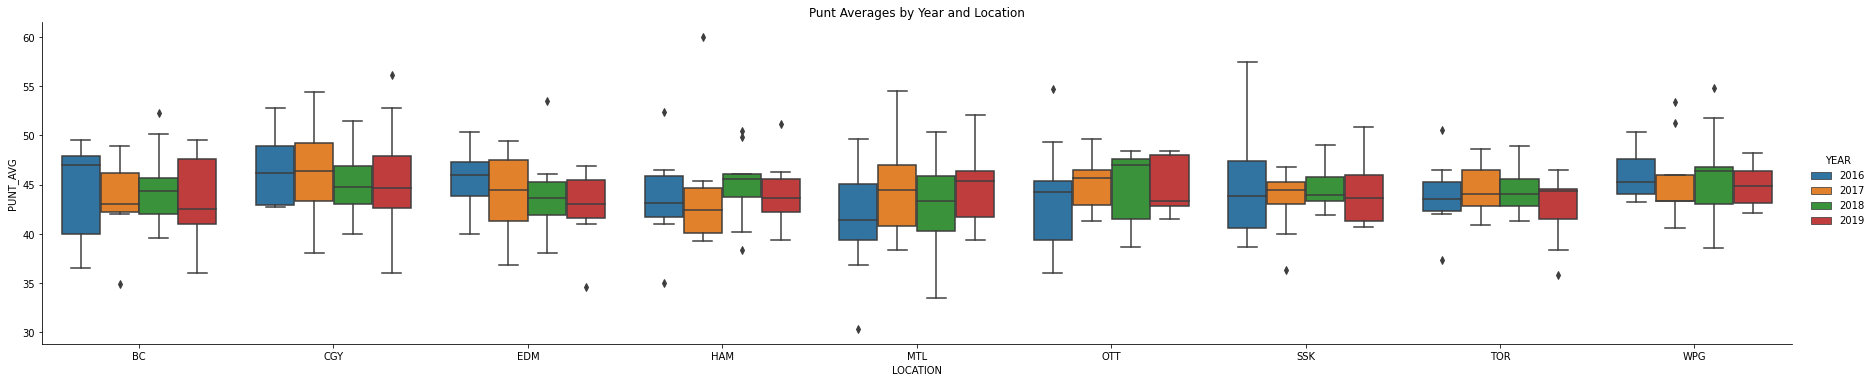

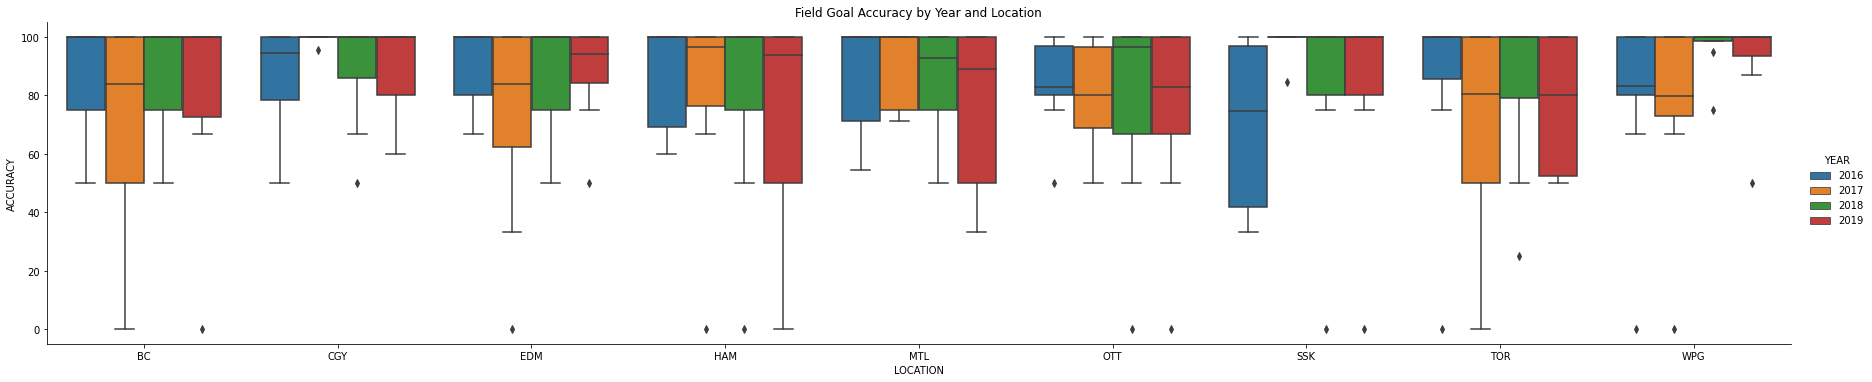

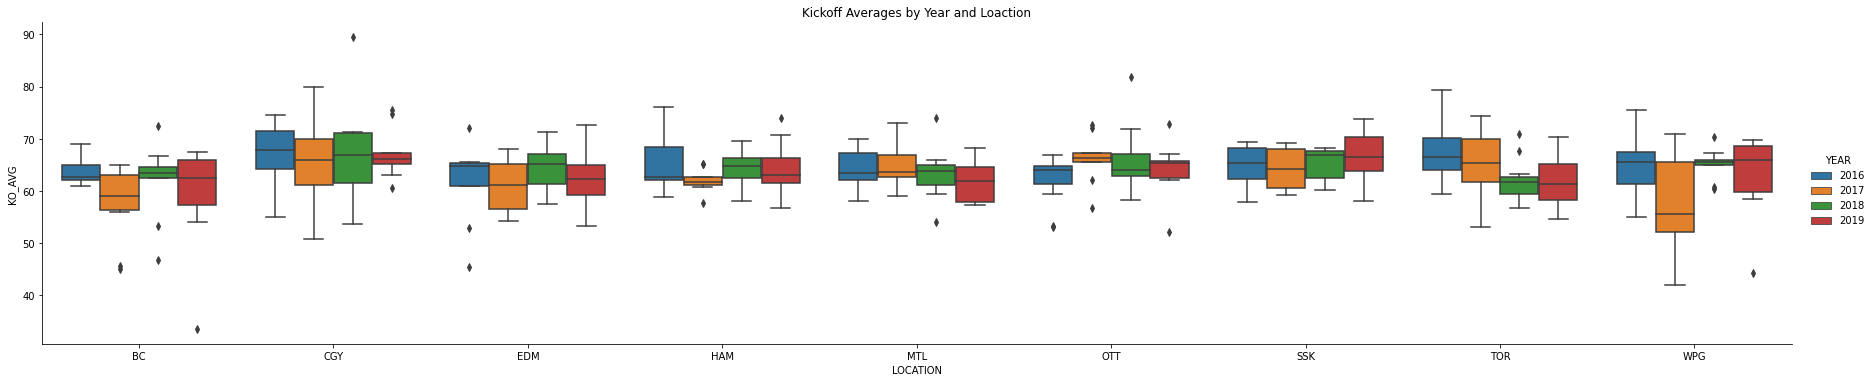

In [64]:
c = sns.catplot(x='LOCATION', y='PUNT_AVG', hue='YEAR', data=df_home_punt_clean, kind='box', aspect=5).set(title='Punt Averages by Year and Location')
d = sns.catplot(x='LOCATION', y='ACCURACY', hue='YEAR', data=df_home_fg_clean, kind='box', aspect=5).set(title='Field Goal Accuracy by Year and Location')
e = sns.catplot(x='LOCATION', y='KO_AVG', hue='YEAR', data=df_home_ko_clean, kind='box', aspect=5).set(title='Kickoff Averages by Year and Loaction')

## See that there some oddities in the data for field goal accuracy in Calgary 2017, WPG 2018, and sask 2017. 
 - showing thaht average is 100% 



In [65]:
check1 = df_home_fg_clean[df_home_fg_clean.YEAR.eq(2017) & df_home_fg_clean.LOCATION.eq('SSK')]
check2 = df_home_fg_clean[df_home_fg_clean.YEAR.eq(2017) & df_home_fg_clean.LOCATION.eq('CGY')]

check1['ACCURACY'], check2['ACCURACY']


(29    100.0
 1      84.6
 23    100.0
 27    100.0
 5     100.0
 9     100.0
 28    100.0
 25    100.0
 Name: ACCURACY, dtype: float64,
 27    100.0
 13    100.0
 8     100.0
 11    100.0
 16    100.0
 23    100.0
 3      95.7
 Name: ACCURACY, dtype: float64)

While seperating the seasons is useful for the individual data points, when plotted it does not provide a very clear picture as to what is happening so I will combine the data to just by location for all years into one boxplot. Checking the anomolies of the fg shows that the data checks out, the away kickers all went 100% on their fgs in those locations for that year. This happened 3 times, where no visiting team kickers missed a field goal at a particular location during one year and this results in odd distributinos in the box plots. Box plots where just looking at accuracy don't take into account the amount of kicks so are not a great visual tool for field goals where a game where a kicker went 1 for 1 is scored equal weight to a game where a kicker went 4 for 4. 

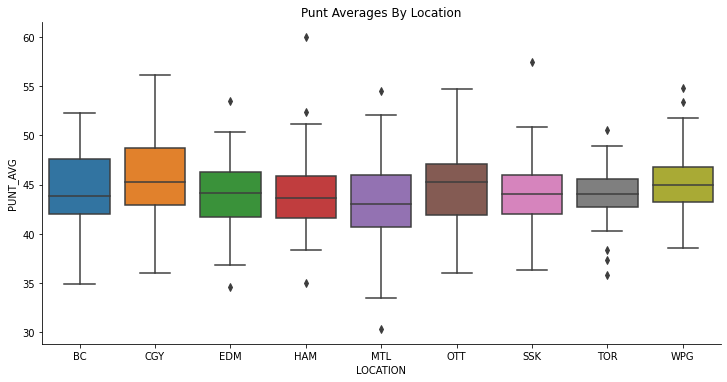

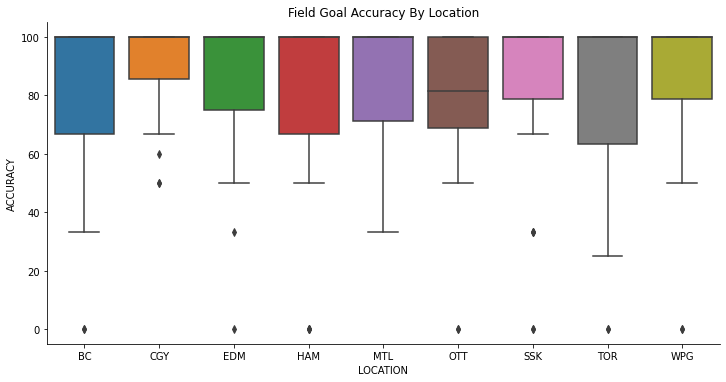

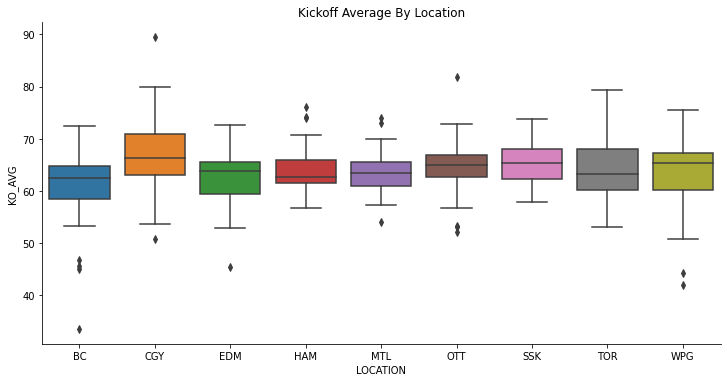

In [66]:
a = sns.catplot(x='LOCATION', y='PUNT_AVG', data=df_home_punt_clean, kind='box', aspect=2).set(title='Punt Averages By Location')
b = sns.catplot(x='LOCATION', y='ACCURACY', data=df_home_fg_clean, kind='box', aspect=2).set(title='Field Goal Accuracy By Location')
c = sns.catplot(x='LOCATION', y='KO_AVG', data=df_home_ko_clean, kind='box', aspect=2).set(title='Kickoff Average By Location')



From these plots it looks that BC is slightly above average when it comes to punting with Calgary (CGY) and Ottawa (OTT) appearing to have the highest averages. The use of boxplots for field goal accuracy does not paint a very clear picture as many of the data points are 100% which is the cap for this data. Overall Calgary again seems to have the most concentrated data near 100% however while it is not apparent if BC is better or worse than the other stadiums. 

## ** TALK ABOUT KICKOFFS IN HERE AS WELL

## Home Field Advantage

One issue I wanted to address with this  data is that the local team kicker or punter statistics in their home stadiums would have a great weighting on that location’s results. They play at home 9 games a year, so their particular abilities could have the potential of skewing the results towards their individual ability because they will generally have about 9 times more data points then the other kickers in the league that compete at that staidum. The most a visiting team will play in an opposing stadium is twice a year while most players will only pay in that stadium once. Excluding the home players results from the data and only including the visiting kickers results in the stadium would result in more evenly weighted data. To account for this I created a second dataset that excluded all kicks and punts from the home team kicker in their respective stadiums so that the results could be compared. 




In [67]:
dn = [home_punt_avgs, away_punt_avgs, home_fg_accuracies, away_fg_accuracies, home_ko_avgs, away_ko_avgs]

dn = pd.concat(dn, axis=1)
dn = dn.drop(['LOCATION'], axis=1)
dn.columns = ['PUNT_AVG_HOME', 'PUNT_AVG_AWAY', 'FG_HOME_ACCURACY', 'FG_AWAY_ACCURACY', 'KO_AVG_HOME', 'KO_AVG_AWAY']

dn

,PUNT_AVG_HOME,PUNT_AVG_AWAY,FG_HOME_ACCURACY,FG_AWAY_ACCURACY,KO_AVG_HOME,KO_AVG_AWAY
LOCATION,,,,,,
BC,45.8,44.0,85.1,83.8,61.4,61.0
CGY,45.9,45.8,89.9,89.6,66.7,66.0
EDM,43.9,43.6,86.4,81.9,61.4,62.5
HAM,44.4,43.6,83.1,81.0,63.5,63.9
MTL,44.0,43.9,82.1,84.0,65.7,62.7
OTT,45.6,45.0,83.3,81.2,64.9,65.5
SSK,44.9,44.2,84.9,88.3,64.4,66.0
TOR,44.6,44.1,81.0,80.9,63.3,64.4
WPG,45.0,45.5,87.2,88.1,64.5,61.6


### Plot all performances vs exclusively away games

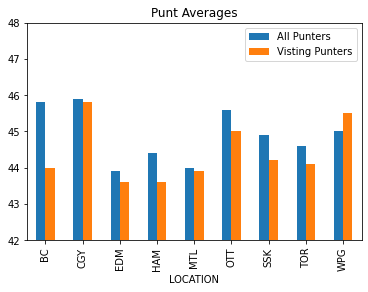

In [68]:
dn_loc = dn.copy()
dn_loc['LOCATION'] = dn.index

ax1 = dn_loc.plot.bar(x='LOCATION', y=['PUNT_AVG_HOME', 'PUNT_AVG_AWAY'], title='Punt Averages')
ax1.set_ylim(42, 48)
ax1.legend(labels=['All Punters', 'Visting Punters'])


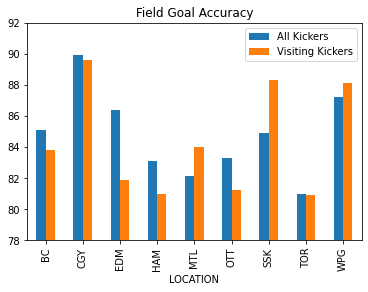

In [69]:
ax2 = dn_loc.plot.bar(x='LOCATION', y=['FG_HOME_ACCURACY', 'FG_AWAY_ACCURACY'], title='Field Goal Accuracy')
ax2.set_ylim(78, 92)
ax2.legend(labels=['All Kickers', 'Visiting Kickers'])

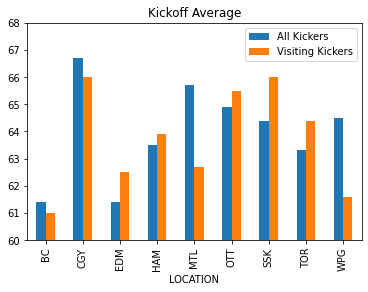

In [70]:

ax3 = dn_loc.plot.bar(x='LOCATION', y=['KO_AVG_HOME',	'KO_AVG_AWAY'], title='Kickoff Average')
ax3.set_ylim(60, 68)
ax3.legend(labels=['All Kickers', 'Visiting Kickers'])

# ** EDIT TO INCLUDE KICKOFF ANALYSIS
## ** Talk about overall if home field brings up or drops performances - analyse

When we compare all games played to only including away games, the most notable difference in punting average is actually in BC where the home punters results have significantly affected the average upwards from 44.0 to 45.8 yards. Field goal accuracy shows a slight drop in accuarcy in BC when removing the home kickers performance. The most notable diffences are in Edmonton (EDM) where the home kickers boost the accuarcy from 81.9% to 86.4% but in Saskatchewan (SSK) the home kickers performances drops the accuarcy from 88.3% to 84.9%. This shows that including the home players performance in the results can have a large impact on the overall results so it makes sense to exclude them going forward or at least keep them seperate. Otherwise we may be interpreting results that are actually just the result of a particularly strong or weak home town player's performaces over a few seasons as opposed to the affect of the location itself. When analyzing the kickoff average results, we can see in Montreal and Winnipeg the home kicker drastically brings up the average at those stadiums. The rest of the stadiums are more similar in their performances but there are still significant differences, whether positive or negative, after removing the home team kicker from the data. 

## Normalize the Data and Visualize


In [71]:
# drop the columns that include the home players in the data
dn_away_only = dn.drop(['PUNT_AVG_HOME', 'FG_HOME_ACCURACY', 'KO_AVG_HOME'], axis=1)
dn_away_only

,PUNT_AVG_AWAY,FG_AWAY_ACCURACY,KO_AVG_AWAY
LOCATION,,,
BC,44.0,83.8,61.0
CGY,45.8,89.6,66.0
EDM,43.6,81.9,62.5
HAM,43.6,81.0,63.9
MTL,43.9,84.0,62.7
OTT,45.0,81.2,65.5
SSK,44.2,88.3,66.0
TOR,44.1,80.9,64.4
WPG,45.5,88.1,61.6


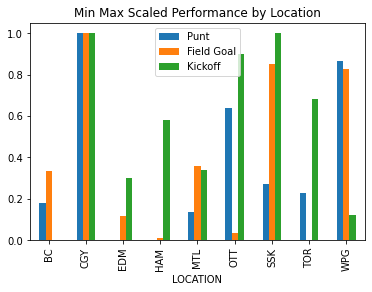

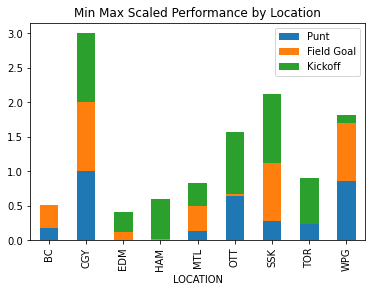

In [72]:
## Minmax Scaler

scaler = preprocessing.MinMaxScaler()
dn_scaled = pd.DataFrame(scaler.fit_transform(dn_away_only), columns=dn_away_only.columns)
# add location back 
dn_scaled['LOCATION'] = dn.index
ax3 = dn_scaled.plot.bar(x='LOCATION', title='Min Max Scaled Performance by Location')
ax3.legend(labels=['Punt', 'Field Goal', 'Kickoff'])
ax4 = dn_scaled.plot.bar(x='LOCATION', title='Min Max Scaled Performance by Location', stacked=True, sort_columns=True)
ax4.legend(labels=['Punt', 'Field Goal', 'Kickoff'])


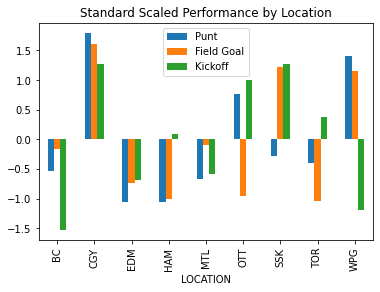

In [73]:
# Standard Scaler
standard_scaler = preprocessing.StandardScaler()
dn_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(dn_away_only), columns=dn_away_only.columns)
dn_standard_scaled['LOCATION'] = dn_away_only.index
ax5 = dn_standard_scaled.plot.bar(x='LOCATION', title='Standard Scaled Performance by Location')
ax5.legend(labels=['Punt', 'Field Goal', 'Kickoff'])

# **UPDATE THIS FOR KICKOFF DATA INCLUDED

Scaling the data was a very useful tool to be able to compare field goals and punts side by side and overall results for stadiums. When plotting scaled data, I found that using the min max scaler technique, where the min is set to 0.0 and max 1.0, was very useful for the stacked bar graph to show overall performance of each location. The standard scaler, where the mean is 0 and values below the mean are negative and above positive, provided a useful visual for comparison across stadiums to very easily see which stadiums were below the mean which was less evident in the min max scaler visualisations. In the first min max bar graph that is not stacked, it is difficult to see the lower performances, especially the wost performances such as in Hamilton and Toronto where there is no bar. This is why I like the standard scaled better. 

Looking at the data overall, Calgary (CGY) has the best performances in both punting and field goals and Winnipeg (WPG) is the next best. Saskatchewan has good field goal accuracy and Ottawa has the next best punting average. The worst performing stadiums are Hamilton followed by Edmonton and Toronto. Toronto had the worst field goal accuarcy performance and Hamilton and Edmonton were tied for the worst overall punting average. The results for BC, the only indoor stadium, show that they are hovering just a little below average in both punting average and field goal accuracy.

## Compare Outdoor vs Indoor (BC) Data

Now I will compare BC to all the other outdoor stadiums. In order to compare the indoor vs outdoor data, a column of the combined performances of all outdoor locations (not BC) will be added to the dataset. This will requiring aggregating all the data from the other locations, mainly field goal attempts and attempts made, then punt yards and number of punts. The location will be labeled as 'OUT' for outdoors.

In [74]:
## add outdoors column to datasets as they are

def add_outdoor_col_punt(df1):
    #get data for each year and punter with location ne BC
    df = df1.copy()
    df_bc = df[df['LOCATION'].eq('BC')]
    df = df[df['LOCATION'].ne('BC')]
    years = df.YEAR.unique()
    players = df.NAME.unique()
    outdoor_data=[]  
    for year in years:
        for player in players:
            num_punt_sum = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), 'NUMBER_OF_PUNTS'].sum()
            punt_yard_sum = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), 'PUNT_YDS'].sum()
            if num_punt_sum > 0:
                out_ave = punt_yard_sum / num_punt_sum
                # temp_df = pd.DataFrame([year, player, 'OUT', num_punt_sum, punt_yard_sum, out_ave])
                outdoor_data.append([year, player, 'OUT', num_punt_sum, punt_yard_sum, out_ave])
            else:
                continue
    column_names = list(df.columns)
    outdoor_df = pd.DataFrame(outdoor_data, columns=column_names)
    df = df.append(outdoor_df)
    # add bc location data back to dataframe with outdoor data
    df = df.append(df_bc)
    df = df.round(1)
    return df

df_away_punt_out = add_outdoor_col_punt(df_away_punt_clean)


ValueError: 7 columns passed, passed data had 6 columns

In [ ]:

def add_outdoor_col_fg(df1):
    #get data for each year and punter with location ne BC
    df = df1.copy()
    #get all data excluding BC data
    df_bc = df[df['LOCATION'].eq('BC')]
    # get list of players and years
    df = df[df['LOCATION'].ne('BC')]
    # get bc location data
    years = df.YEAR.unique()
    players = df.NAME.unique()
    outdoor_data=[]  
    # get column names for df
    column_names = list(df.columns)
    for year in years:
        for player in players:
            #get total attempst and made for each player in each year
            sum_fg_attempts = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), 'FG_ATTEMPTS'].sum()
            sum_fg_made = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), 'FG_MADE'].sum()
            if sum_fg_attempts > 0:
                # calculate accuracy
                out_percentage = (sum_fg_made / sum_fg_attempts) * 100
                # get sums of the rest of numeric data
                details_data = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), ['lt_20', '20_29', '30_39', '40_49', 'gte_50', 'C1_ATT', 'C1_MADE']].sum()
                details_data = details_data.round()
                # create an empty df
                temp_df = pd.DataFrame([], columns=column_names)
                # add distance details to df
                temp_df = temp_df.append(details_data, ignore_index=True)
                # add player year location fg made and attempt data to df
                temp_df = temp_df.assign(YEAR=year, NAME=player, LOCATION='OUT', FG_ATTEMPTS=sum_fg_attempts, FG_MADE=sum_fg_made, ACCURACY=out_percentage)
                # add df to array
                outdoor_data.append(temp_df)                
            else:
                continue
    # outdoor_df = pd.DataFrame(outdoor_data, columns=column_names)
    dn = pd.concat(outdoor_data, axis=0, )
    df = df.append(dn)
    # add bc data back to dataframe
    df = df.append(df_bc)
    df = df.round(1)
    return df

df_away_fg_out = add_outdoor_col_fg(df_away_fg_clean)

## Visualizations of Indoors (BC) vs Outdoors
# ** ADD KICKOFFS

In [ ]:
# create new dataframe that includes only the data for Outdoors and BC
df_away_punt_out_bc = df_away_punt_out[df_away_punt_out['LOCATION'].isin(['OUT','BC'])]
df_away_fg_out_bc = df_away_fg_out[df_away_fg_out['LOCATION'].isin(['OUT','BC'])]

In [ ]:

o = sns.catplot(x='LOCATION', y='PUNT_AVG', data=df_away_punt_out_bc, kind='box').set(title='Outdoor Vs Indoor Punt Averages')
p = sns.catplot(x='LOCATION', y='ACCURACY', data=df_away_fg_out_bc, kind='box').set(title='Outdoor Vs Indoor Field Goal Accuracies')

## Get Outdoor Overall Punt Average and Field Goal Accuracy

In order to get the overall punt average for outdoor stadiums, the total amount of yards must be summed and divided by the total amount of punts. Otherwise if we just take the average of the punt averages, a game with one punt of 70 yards would have the same weight as a 10 pnut game which averaged 45 yards. Same goes for field goals, the total number of successfull made field goals must be added together and divided by the total number of field goal attempts to get the overall accuarcy. 

In [ ]:
def get_overall_punt_avg(df):
    sum_df = df.groupby('LOCATION').sum()
    sum_df['OVERALL_AVG'] = sum_df['PUNT_YDS'] / sum_df['NUMBER_OF_PUNTS'] 
    return sum_df['OVERALL_AVG'].round(1)

get_overall_punt_avg(df_away_punt_out_bc)

In [ ]:
def get_overall_fg_accuracy(df):
    sum_df = df.groupby('LOCATION').sum()
    sum_df['OVERALL_ACCURACY'] = sum_df['FG_MADE'] / sum_df['FG_ATTEMPTS']
    sum_df = sum_df.transform(lambda x: x*100)
    return sum_df['OVERALL_ACCURACY'].round(1)

get_overall_fg_accuracy(df_away_fg_out_bc)

When we aggregate all the outdoor stadiums data to compare to the indoor stadium in BC we find that the punting average for away only games is actually below outdoor stadiums. Punters averaged 44.0 yards per punt in BC while outdoors the average was 44.5 yards so players performanced better overall outdoors than indoors in BC. When looking at the aggregate of field goal accuracy, they are extremely close. Overall field goal accuracy was very similar in BC place compared to outdoor stadiums. Over the 4 seasons visiting kickers accuarcy was 83.8% while visiting kicker's accuracy in outdoor stadiums totalled 84.1%.

## Preliminary Look At Individual Performances

In the future of this project I will analyze the results of indivudal players performances across stadiums. For the purposes of this preliminary report I will organize the data in order to show a proof of concept and display some basic plots that could be used in the full report going forward.

In [ ]:
df_punt_pivot = df_away_punt_clean.copy()
df_punt_pivot = pd.pivot_table(df_punt_pivot, values=['NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG'], index=['YEAR', 'NAME'], columns=['LOCATION'], fill_value=0)

df_punt_pivot

In [ ]:
df_fg_pivot = df_away_fg_clean.copy()
df_fg_pivot = pd.pivot_table(df_fg_pivot, values=['FG_MADE', 'FG_ATTEMPTS', 'ACCURACY'], index=['YEAR', 'NAME'], columns=['LOCATION'], fill_value=0)

df_fg_pivot

## Remove rows with punters who do not have any data for BC

There are instances of punters and kickers who may have season data where they did not actually kick in BC for that year. Without them performing in BC there is no way to compare their indoor performances to their outdoors so they will be removed from the data. This is done by filteroung out players with 0 field goal attempts or 0 punts in BC for that season.

In [ ]:
df_punt_pivot_clean = df_punt_pivot[df_punt_pivot.NUMBER_OF_PUNTS.BC.gt(1)]
df_fg_pivot_clean = df_fg_pivot[df_fg_pivot.FG_ATTEMPTS.BC.gt(1)]


In [ ]:
# check results of punt dataset - make sure BC NUMBER_OF_PUNTS all greater than 0
df_punt_pivot_clean.head()

In [ ]:
# check results of punt dataset - make sure BC.FG_ATTEMTPTS all greater than 0
df_fg_pivot_clean.head()

## Create outdoor column to add to each player

In [ ]:
def add_out_location_for_punt_pivot_df(df):
    #get number of punts for all non bc games
    df1 = df.copy()
    df1.loc[:, ['NUMBER_OF_PUNTS']].iloc[: , 1:-1]

    #create column of number of outdoor punts = sum of all punts not in BC
    df1['NUMBER_OF_PUNTS', 'OUT'] = df1.loc[:, ['NUMBER_OF_PUNTS']].iloc[: , 1:-1].sum(axis=1)

    #create column of total punt yards outdoors = sum of all punt yards not in BC
    df1['PUNT_YDS', 'OUT'] = df1.loc[:, ['PUNT_YDS']].iloc[: , 1:-1].sum(axis=1)

    #create colum of punt average outdoors = outdoor punt yards / outdoor number of punts
    df1['PUNT_AVG', 'OUT'] = df1.PUNT_YDS.OUT / df1.NUMBER_OF_PUNTS.OUT
    # 
    df1 = df1.round(1)
    return df1

df_punt_pivot_clean_out = add_out_location_for_punt_pivot_df(df_punt_pivot_clean)
df_punt_pivot_clean_out.head()


In [ ]:
def add_out_location_for_fg_pivot_df(df):
    #get number of field goals attempted for non bc games
    df1 = df.copy()
    df1.loc[:, ['FG_ATTEMPTS']].iloc[: , 1:-1]

    #create column of number of outdoor field goal attempts = sum of all field goals not in BC
    df1['FG_ATTEMPTS', 'OUT'] = df1.loc[:, ['FG_ATTEMPTS']].iloc[: , 1:-1].sum(axis=1)

    #create column of total field goals made outdoors = sum of all field goals made not in BC
    df1['FG_MADE', 'OUT'] = df1.loc[:, ['FG_MADE']].iloc[: , 1:-1].sum(axis=1)

    #create colum of accuracy outdoors = outdoor field goals made / outdoor field goals attempted
    df1['ACCURACY', 'OUT'] = df1.FG_MADE.OUT / df1.FG_ATTEMPTS.OUT * 100
    # 
    df1 = df1.round(1)
    return df1

df_fg_pivot_clean_out = add_out_location_for_fg_pivot_df(df_fg_pivot_clean)
df_fg_pivot_clean_out.head()

## Create some player data plots of Indoors Vs Outdoors

In [ ]:
# fg_plot_data = df_fg_pivot_clean_out[['ACCURACY']]
ax6 = df_fg_pivot_clean_out[['ACCURACY']].loc[:, :].iloc[: , [0,-1]].plot.barh(xlim=[30, 100], figsize=(5,12))
ax6.set(title='Player FG Accurcay Indoors vs Outdoors')
ax6.legend(labels=['Indoors', 'Outdoors'])

In [ ]:
ax7 = df_punt_pivot_clean_out[['PUNT_AVG']].loc[:, :].iloc[: , [0, -1]].plot.barh(xlim=[34,53], figsize=(5,12))
ax7.set(title='Player Punt Average Indoors vs Outdoors')
ax7.legend(labels=['Indoors','Outdoors'])

These visualizations do not provide much insight into the data but show that further analysis is possible. To get a better understanding of the results, it would make sense to analyse the difference of each data points performance between outdoor and indoor performance and combine them into one metric vs two. This could then be plotted and analysed to see overall trends amongst the whole dataset instead of the individual data points as seen above.



## Initial Summary and Analysis

Looking at the away performance data, punting performances were the best overall in Calgary, Ottawa (OTT), and Winnipeg (WPG) while the worst punting was in Edmonton, Hamilton (HAM), and Montreal (MTL).  The best field goal performances were in Calgary (CGY), Saskatchewan (SSK), and Winnipeg (WPG) while the worst were in Toronto (TOR), Hamilton (HAM), and Ottawa (OTT). It would appear that Edmonton (EDM), Hamilton (HAM), Montreal (MTL), and Toronto (TOR) have the worst performance outcomes overall. Hamilton, Montreal, and Toronto are all in the Eastern division and possibly more importantly, the Eastern time zone. Studies have shown that travel from West to “East has a greater detrimental effect on sleep, subjective jet lag, fatigue, and motivation” (https://pubmed.ncbi.nlm.nih.gov/28719491/). This could be a possible reason for the subpar performances in this grouping of stadiums. 

Looking at the consistent top performance across both field goals and punting in Calgary, it could possibly be a result of the higher elevation of the city. The higher the elevation, the lower the air density and the lower the air density, the less air molecules there are in the path of the ball to slow it down. "A punted or kicked football will run headlong into a steady barrage of air molecules. Their combined drag will slow it down, sometimes dramatically. But remember, in low density air, molecules are fewer and farther between" (https://entertainment.howstuffworks.com/physics-and-football-denvers-altitude-affect-field-goals.htm). Calgary’s elevation is 1045m above sea level while the next highest city, Edmonton, is only 645m. BC is located at sea level so this could be a key as well as to why performances don’t increase as much as one would expect being indoors. Toronto, Montreal and Hamilton all have very low elevations as well and had below average performances. However, Ottawa is also a lower elevation city and while it had below average field goal accuracy, it had well above average punting performances.

Another reason why BC may not have the punting performance results as anticipated is how punt distance is measured. Punt yardage is calculated by where the ball is actually picked up, not where it initially lands. In games with tough conditions, these conditions can also be tough for the returner who’s job is to catch the ball. If the returner is unable to catch the ball in the air due to a wild punt in a high wind game, there is a chance the ball can bounce past the returner. The punt is then recorded as a longer distance even though the punter may have not actually hit the ball very well. This poses an interesting idea that it may turn out that while indoor stadiums are favourable to the punter for consistent contact and accuracy, this may also play in favour of the returner for overall easier to catch punts. It would be interesting to see if there was more consistency, or less variance, overall in punting average in BC camparde to the other stadiums.

# DETAILED KICKING DATA
Use data that contains individual field goal results. 
Data is for each field goal kicked, includes location, team, distance, whethere it was missed or made.  
This improves upon the CFL data as the CFL data does not contain detailed information for kicks that were missed.
This way we can look more closely at mid range to long range field goals where elements will be more of a factor than just mental errors. If a particular stadium has a higher percentage of shorter kicks for whatever reason, this could skew the results to it being a better stadium field goal performance wise when in actuality it is just because there has been a higher proportion of shorter, high percentage field goals. 

# DETAILED PUNTING DATA
Use data that contains individual punt results, in this case net punt data. This is the field position actually obtained from the punt rather than the total distance the punt went. This is more of a team metric than individual punter but could lead to useful insights as well and is worth exploring. 

## Import Excel Data


In [ ]:
fg_data_df = pd.read_excel('fg_data.xlsx', engine='openpyxl')
punt_data_df = pd.read_excel('punt_net_data.xlsx', engine='openpyxl')
fg_data_df.head()



In [ ]:
punt_data_df.head()

In [ ]:
def clean_detailed_fg(df):
   # drop columns not interested in
   df = df.drop(['Regular/Playoffs', 'Game', 'Play by play text', 'Single'], axis=1)
   df = df.rename(columns={'Stadium':'LOCATION', 'Year':'YEAR', 'Distance':'DISTANCE', 'Kicker':'NAME', 'Indoor/Outdoor': 'INOUT', 'Home':'HOME', 'Made':'MADE', 'Miss':'MISS', 'H/A':'HOMEAWAY'})
   # fill in nan values with 0 for Made col
   df['MADE'] = df['MADE'].fillna(0)
   df['MISS'] = df['MISS'].fillna(0)
   # replace Y and y in Made col with 1 to make it a binary column
   df = df.replace({'MADE': {'Y': 1, 'y': 1}})
   return df

def clean_detailed_punt(df):
   df = df.drop(['PLAY-BY-PLAY'], axis=1)
   df = df.rename(columns={'HOME':'LOCATION'})
   df['SINGLE'] = df['SINGLE'].fillna(0)
   return df

fg_data_df_clean = clean_detailed_fg(fg_data_df)
punt_data_df_clean = clean_detailed_punt(punt_data_df)


# Field Goal Analysis
Determine at what range field goal accuracy begins to decline significantly. Then will use this range to compare across stadiums.
Get the overal accuracy at different distances for field goals and plot results.



In [ ]:
def get_accuracy(df):
   made_fgs = (df['MADE'] == 1).sum()
   missed_fgs = (df['MADE'] == 0).sum()
   accuracy = (made_fgs / (made_fgs + missed_fgs)).round(3)*100
   return accuracy

def get_distance_accuracies(df):
   df015_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 0) & (df['DISTANCE'] <= 15)]) 
   df1629_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 16) & (df['DISTANCE'] <= 29)])
   df3035_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 30) & (df['DISTANCE'] <= 35)])
   df3640_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 36) & (df['DISTANCE'] <= 40)])
   df4145_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 41) & (df['DISTANCE'] <= 45)])
   df4650_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 46) & (df['DISTANCE'] <= 50)])
   df51_acc = get_accuracy(df.loc[(df['DISTANCE'] >= 51)])
   accuracies = [df015_acc,df1629_acc, df3035_acc,df3640_acc, df4145_acc, df4650_acc, df51_acc]
   return(accuracies)

fg_dist_accs = get_distance_accuracies(fg_data_df_clean)

plt.bar(['0-15', '16-29', '30-35', '36-40', '41-45', '46-50','51+'],fg_dist_accs)
plt.ylim(40,100)
plt.xlabel('Field Goal Distance (yards)')
plt.ylabel('Accuracy (%)')
plt.title('Field Goal Accuarcy by Distance')

### See that Accuracies are near 100% up until the 30 yard range when there is a large drop off to about 85%.  
### So for our FG data going forward we will use only field geals kicked from 30 yards and beyond to eliminate kicks that have little chance of missing.
### This is so that if one stadium happens to have a higher % of shorter distance fgs this will not skew the data to it being a more accurate stadium.

In [ ]:
def remove_short_fgs(dist, df):
   new_df = df.loc[df['DISTANCE'] > dist]
   return new_df

long_fg_data = remove_short_fgs(29, fg_data_df_clean)

print('ALL FG MAKES AND MISSES DATA COUNT: \n', fg_data_df_clean['MADE'].value_counts())
print('LONG FG MAKES AND MISSES DATA COUNT: \n', long_fg_data['MADE'].value_counts())

By eliminating short fieldgoals with a high rate of accuracy, those field goals from 29 yards and in, we have removed 655 made fieldgoals but only 14 misses which is an accuracy rate of 97.9%.   
Field goal accuracy from 30 and beyond is 78%.   
Now we will break up the data into locations and look at accuracy in each location from 30 yards and beyond.







In [ ]:
def get_location_fg_accuracies(df):
   #  total_attempts = df['FG_ATTEMPTS'].groupby(df['LOCATION']).sum()
   total_makes = (df['MADE'] == 1).groupby(df['LOCATION']).sum()
   total_misses = (df['MADE'] == 0).groupby(df['LOCATION']).sum()
   accuracies = (total_makes / (total_misses + total_makes) *100).round(1)
   new_df = pd.DataFrame(accuracies)
   return new_df
    
def get_location_net_punts(df):
   total_net = df['NET'].groupby(df['LOCATION']).sum()
   total_punts = (df['LOCATION']).value_counts()
   net_ave = (total_net / total_punts).round(2)
   new_df = pd.DataFrame(net_ave, columns=['NET_PUNT_AVE'])
   return new_df


# home_fg_accuracies = get_location_fg_accuracies(df_home_fg_clean)
# away_fg_accuracies = get_location_fg_accuracies(df_away_fg_clean)
long_fg_acc_df = get_location_fg_accuracies(long_fg_data)
all_fg_acc_df = get_location_fg_accuracies(fg_data_df_clean)


away_long_fg_data = long_fg_data[long_fg_data.HOMEAWAY.eq('A')]
home_long_fg_data = long_fg_data[long_fg_data.HOMEAWAY.eq('H')]

long_fg_acc_away_df = get_location_fg_accuracies(away_long_fg_data)
long_fg_acc_home_df = get_location_fg_accuracies(home_long_fg_data)

# get_location_net_punts(punt_data_df_clean)

In [ ]:
# plot these all together, har chart
df_fg_acc = [all_fg_acc_df, long_fg_acc_df, long_fg_acc_away_df, long_fg_acc_home_df]
df_fg_acc = pd.concat(df_fg_acc, axis=1)
# df_fg_acc = df_fg_acc.drop(['LOCATION'], axis =1)
df_fg_acc.columns = ['ALL_FGS', 'LONG_FGS', 'LONG_AWAY_FGS', 'LONG_HOME_FGS']

df_fg_acc['ACCURACY_CHANGE_REMOVING_SHORT_FGS'] = df_fg_acc['ALL_FGS'] - df_fg_acc['LONG_FGS']
df_fg_acc['DIFF_REMOVING_HOME_KICKERS'] = df_fg_acc['LONG_FGS'] - df_fg_acc['LONG_AWAY_FGS']

df_fg_acc
# df_fg_acc.plot.bar(subplots=True, layout=(4,2), figsize=(16,8), sharey=True)

In [ ]:
ax0 = df_fg_acc.sort_values(
      by=['ACCURACY_CHANGE_REMOVING_SHORT_FGS']
   ).plot.bar(
      title='Decrease in FG Accuracy when Removing Short Fgs (< 30 yards)', 
      y=['ACCURACY_CHANGE_REMOVING_SHORT_FGS'],
      legend=False
   )
# ax0.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax0.set_ylim(4,10)
ax0.axhline(df_fg_acc['ACCURACY_CHANGE_REMOVING_SHORT_FGS'].mean(), color='orange')
ax0.invert_yaxis()
for container in ax0.containers:
   ax0.bar_label(container)

# this could be a scaled graph - to show relative differences



ax1 = df_fg_acc.sort_values(
      by=['ALL_FGS']
   ).plot.bar(
      title='Field Goal Accuracy All Distances', 
      y=['ALL_FGS'], 
      legend=False
   )
ax1.set_ylim(80, 92)
# ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
for container in ax1.containers:
   ax1.bar_label(container)

ax3 = df_fg_acc.sort_values(
      by=['LONG_FGS']
   ).plot.bar(
      title='Field Goal Accuracy 30+ Yards', 
      y=['LONG_FGS'], 
      legend=False
   )
ax3.set_ylim(70, 84)
# ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
for container in ax3.containers:
   ax3.bar_label(container)



In [ ]:
# Standard Scaler
standard_scaler = preprocessing.StandardScaler()
fg_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(df_fg_acc), columns=df_fg_acc.columns)
fg_standard_scaled['LOCATION'] = df_fg_acc.index
ax5 = fg_standard_scaled.plot.bar(
      x='LOCATION',
      y=['ACCURACY_CHANGE_REMOVING_SHORT_FGS'], 
      title='Standard Scaled FG Accuracy by Location'
   )
ax5.legend(labels=['Change'])


Min max shows relative change, green shows min max of change - so in this case mtl had the greatest difference so the highest proportion of short fgs while hamilton had the least

# ** NEEDS EDITTING
# plot difference in accuracy after removing short fgs, showing how a higher percentage of short fgs could skew the data for one location over others
### orange line shows average, larger the bar, the larger the decrease in accuarcy meaning the more fgs that were in the short range at that location
### find that Montreal and Ottawa had the biggest drops in accuracy, so meaning they had a more signifincant amount of attempts from the high accuracy range
### whereas hamilton had the lowest change in %, meaning a higher proportion of fgs attempted in Hamilton were from 30 yards and beyond
### Edmonton, Montreal, Ottawa, Toronto were above the average drop in accuracy, so higher proportion of shorter fgs
### Calgary, Hamilton, Sask, Winnipeg all had below average drops in accuarcy so lower proportion of shorter high accuracy fgs
### BC was right on the average


# Plot Home Vs Away FG Accuracies
## Home kicker has about half the data at each location for each year, so significantly skew the data, maybe could could do something to reduce their weighting? otherwise seperate
## Find that some kickers improve overall accuracy and some worsen accuracy
## BC, Edmonton, Hamilton, Ottawa all improved the overall accuarcy of their respective stadiums
## Calgary, Montreal, Sask, Toronto, and Winnipeg actually worsened overall accuracy 
## Biggest change is in Montreal, most significant difference between Home performance and Away

In [ ]:

ax2 = df_fg_acc.sort_values(
      by=['LONG_HOME_FGS']
   ).plot.bar(
      title='Field Goal Accuracy by Location (Home Vs Away)', 
      y=['LONG_HOME_FGS', 'LONG_AWAY_FGS'], 
      width=0.8
   )
ax2.set_ylim(65, 90)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax3 = df_fg_acc.plot.bar(
      title='Field Goal Accuarcy Difference After Removing Home Field Kicks', 
      y=['DIFF_REMOVING_HOME_KICKERS'], 
      legend=False
   )

for container in ax3.containers:
   ax3.bar_label(container)



## Results
Can see that BC, Edmonton, Hamilton, Ottawa kickers all increased the overall accuarcy at their home stadiums  
Calgary, Montreal, Sask, Toronto, Winnipeg's home team kickers actually reduced the accuarcy at their home fields.   
Seperate the home field kickers as they have a much heavier weighting and can skew the results to their own

# Kickoffs: Elevation and Temperature
After looking at the preliminary plots, the data showed that the highest kickoff averages were in Calgary and lowest were in BC, it made sense to look at whether or not elevation plays a factor in kickoff distance.   
Using the current kickoff data and then including the elevation above sea level in the data for each location, we can then see if there is any correlation between elevation and kickoff average.  
Elevations for each stadium were taken from https://en-ca.topographic-map.com/ and are in meters above sea level.  

Weather is collected from https://climate.weather.gc.ca/ and the data for weather is the average daily temperature in September for 1981 - 2010. I chose the month of september as that is the halfway point of the CFL season. 

In [ ]:
elevations = [11, 1102, 662, 89, 70, 72, 580, 82, 232]
temperatures = [14.9, 11.0, 11.4, 15.8, 14.1, 15.0, 11.8, 17.2, 12.7]

home_ko_avgs['TEMPERATURE'] = temperatures
away_ko_avgs['TEMPERATURE'] = temperatures

home_ko_avgs['ELEVATION'] = elevations
away_ko_avgs['ELEVATION'] = elevations

sns.regplot(
      y=away_ko_avgs['KO_AVG'], 
      x=away_ko_avgs['ELEVATION'], 
      color='green',
      ci=80
   ).set_title('Kickoff Averages Visiting Kickers')

# sns.regplot(y=home_ko_avgs['KO_AVG'], x=home_ko_avgs['ELEVATION'])

for i in range(away_ko_avgs.shape[0]):
   plt.text(x=away_ko_avgs.ELEVATION[i]+0.3,y=away_ko_avgs.KO_AVG[i]+0.3,s=away_ko_avgs.LOCATION[i], 
      fontdict=dict(color='red',size=10),
      bbox=dict(facecolor='yellow',alpha=0.5))

In [ ]:
x = (away_ko_avgs['ELEVATION'].values).reshape(-1,1)
y = away_ko_avgs['KO_AVG'].values.reshape(-1,1)
model = LinearRegression().fit(x,y)
y_pred = model.predict([[0]])
print(' R2: ', model.score(x,y), '\n Slope: ', model.coef_[0][0], '\n Intercept: ', model.intercept_)

Distance = 62.9 + 0.25*Elevation(100m)
This model finds that elevation explains 26.2% of the variation in kickoff distance. A 1000m jump in elevation, results in a 2.5 yard boost in kickoff distance. This is in line with the theory that the lower air density at higher elevations will result in less drag on objects in the air, resulting in longer distances kicked. There are a couple outliers in the data, 

In [ ]:
# remove bc because it is indoors so therefore temperature is controlled and not subject 
no_bc_away_ko_avgs = away_ko_avgs[away_ko_avgs.LOCATION.ne('BC')]
no_bc_away_ko_avgs
sns.regplot(y=no_bc_away_ko_avgs['KO_AVG'], x=no_bc_away_ko_avgs['TEMPERATURE'], color='red')

x = (no_bc_away_ko_avgs['TEMPERATURE'].values).reshape(-1,1)
y = no_bc_away_ko_avgs['KO_AVG'].values.reshape(-1,1)
model = LinearRegression().fit(x,y)
y_pred = model.predict([[0]])
print(' R2: ', model.score(x,y), '\n Slope: ', model.coef_[0][0], '\n Intercept: ', model.intercept_)

By looking at the plot of average temperature and kickoff average can not see much of a correlation. While there may certainly be a difference in distance kicked in more extreme temperature changes from summer to late fall, overall all stadiums are similar in their relative temperature changes as the year goes on so the effect is likely similar across locations. The R squared value was 0.005 so temperature explained only 0.5% of the variation in kickoff averages which is very poor. 

# ** EDIT THIS
# Jetlag West Travel to East
## Check how BC kickers did in Eastern provinces compared to alberta
## Continue use of only longer FGs (30+ yards)
### jetlag at least 2 timezones of travel 

### west to east travel (hardest in theory)

### Vancouver to WPG and beyond + AB to ONT

### east to west travel (easier)

### ONT to AB and BC + WPG to BC
### jetlag source https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3435929/






In [ ]:
def get_fgs_of_team_in_loc(df, kickers_teams, away_stadiums):
   home_kicker_df = df[df.TEAM.isin(kickers_teams)]
   home_kicker_df = home_kicker_df[home_kicker_df.HOME.isin(away_stadiums)]
   return home_kicker_df
   

# WEST TO EAST TRAVEL 2+ TIMEZONES TRAVELED
bc_ab_to_ont_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['BC','EDM','CGY'], ['TOR','OTT','MTL','HAM'])
bc_to_wpg_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['BC'], ['WPG'])
# combine
west_to_east_travel = pd.concat([bc_ab_to_ont_travel, bc_to_wpg_travel])

# EAST TO WEST TRAVEL 2+ TIMEZONES TRAVELED
ont_to_ab_bc_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['TOR','OTT', 'MTL', 'HAM'], ['BC','EDM','CGY'])
wpg_to_bc_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['WPG'], ['BC'])
# combine
east_to_west_travel = pd.concat([ont_to_ab_bc_travel, wpg_to_bc_travel])

# LOCAL TRAVEL - 0-1 TIMEZONES TRAVELED
bc_ab_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['BC','EDM','CGY'], ['BC','EDM','CGY'])
ab_sask_wpg_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['EDM','CGY','SSK','WPG'], ['EDM','CGY','SSK','WPG'])
wpg_ont_travel = get_fgs_of_team_in_loc(away_long_fg_data, ['TOR','OTT','MTL','HAM','WPG'], ['TOR','OTT','MTL','HAM','WPG'])
# combine
one_timezone_travel = pd.concat([bc_ab_travel, ab_sask_wpg_travel, wpg_ont_travel])


fg_acc_west_to_east_travel = get_accuracy(west_to_east_travel) 
fg_acc_east_to_west_travel = get_accuracy(east_to_west_travel) 
fg_acc_one_timezone_travel = get_accuracy(one_timezone_travel)
fg_acc_no_travel_home = get_accuracy(home_long_fg_data)





In [ ]:
jetlag_index = [
   'East Travel (2+ Timezones)', 
   'West Travel (2+ Timezones)', 
   '0 or 1 Timezone (Either Direction)', 
   'No Travel (Home Kicker'
]

jetlag_df = pd.DataFrame(
   data={'FG_ACCURACY': [
      fg_acc_west_to_east_travel,
      fg_acc_east_to_west_travel,
      fg_acc_one_timezone_travel,
      fg_acc_no_travel_home
   ]}, 
   index=jetlag_index
)

ax4 = jetlag_df.plot.bar(
   title='Field Goal Accuracy by Travel Type', 
   width=0.8, 
   legend=False
)
ax4.set_ylim(70, 80)
for container in ax4.containers:
   ax4.bar_label(container)

# ** EDIT THIS

## As expected in results, find that local travel (0-1 timezones travelled) had the highest fg accuracy
## this currently includes home field kickers? does this matter?
## Find that East to west travel not that large of a dropoff in accuracy - drops 2.6% from local travel
## Find that West to East travel has the lowest accuarcy - 72.2 % which is 6.5% less than local travel


## Conclusion and Further Work

Overall from this preliminary analysis we can see that Calgary is the front runner when it comes to the performance metrics used, punting average and field goal accuracy. There does not appear to be an advantage to indoor punting average and field goal accuracy over the four seasons measured. To further this analysis I will take individual punters and field goal kickers results and compare their own performances against themselves across stadiums. This could potentially be a more accurate way to control for individual player's perforrmances and reduce outliers. 

I would also like to look at the effect of elevation on the kicking game to see if that explains some of the differences between stadiums. The preliminary results showed Calgary, the highest elevation stadium in the league, to have the best performance results for both punting and field goals and this is worth exploring further. Including kickoffs in this analysis would be a good way to determine the effect as kickoffs have less variables affecting the outcome of the kick, they are primarily just about kicking the ball as far as the kicker can and it is rare for the ball to not be caught by the returner. I would also like to look into more detail about the distances of the field goals made and see if I can include those in the data and to help reduce the weight of short field goals possibly skewing the data as well as they are not a great determinate of how tough the outdoor conditions are. However this data may not be available so would have to do some analysis with the data available, the distances of the successfully made field goals. Including converts in the analysis would be useful as well. Converts  are a mid range kick (32 yards) and including them would help boost the number of data points for field goal accuracy and reduce the weight of short range field goals. 

I think it would also be worthwhile to look further into the effect of jet lag affecting performance. The study by Fowler PM, Knez W, Crowcroft S, Mendham AE, Miller J, Sargent C, Halson S and Duffield R. found that "Long-haul transmeridian travel can impede team sport physical performance. Specifically, east travel has a greater detrimental effect on sleep, subjective jet lag, fatigue, and motivation." The greatest travel is from West to East is BC travelling to Hamilton, Toronto, Ottawa, and Montreal which is across three timezones. Conducting an analysis of BC kickers and punters travelling east could have interesting results as well.  

### References

Official site of the Canadian Football League. CFL.ca. (n.d.). https://www.cfl.ca/

Fowler PM, Knez W, Crowcroft S, Mendham AE, Miller J, Sargent C, Halson S, Duffield R. Greater Effect of East versus West Travel on Jet Lag, Sleep, and Team Sport Performance. Med Sci Sports Exerc. 2017 Dec;49(12):2548-2561. doi: 10.1249/MSS.0000000000001374. Erratum in: Med Sci Sports Exerc. 2018 Feb;50(2):391. Sargent, Charlie (corrected to Sargent, Charli). PMID: 28719491.

Mancini, M. (2018, December 24). Physics and Football: How Denver's Altitude Affects Field Goals. HowStuffWorks. https://entertainment.howstuffworks.com/physics-and-football-denvers-altitude-affect-field-goals.htm. 


